In [43]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import optax
from tqdm import tqdm, trange
import flax

import math
from functools import partial
import matplotlib.pyplot as plt

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

from models.mlp_mixer import MLPMixer
from models.utils import timestep_embedding, timestep_discretization, TrainState, apply_ema_decay

In [81]:
# Config
num_batch = 16
d_t_emb = 4
sigma_data = 0.5
s0 = 2
s1 = 150
sigma = 7.
mu0 = 0.9
eps = 0.002
T = 80.0

In [82]:
def get_mnist_dataset(split, batch_size):
    """Returns an iterator over the MNIST dataset."""
    # Load the dataset and prepare it for batching
    ds = tfds.load('mnist', split=split, shuffle_files=True if split == "train" else False)
    ds = ds
    
    # Define a function to preprocess each batch
    def preprocess(batch):
        mean, std = 0.1307, 0.3081
        images = batch['image']
        # Flatten the images and normalize their pixel values to [0, 1]
        images = tf.cast(images, tf.float32) / 255
        images = (images - mean) / std
        labels = batch['label']
        return images, labels
    
    # Map the preprocessing function to each batch
    ds = ds.map(preprocess).batch(batch_size).cache().repeat()
    
    # Return an iterator over the preprocessed batches
    return iter(ds)

batches = get_mnist_dataset("train", num_batch)

In [83]:
import einops
import flax.linen as nn
import jax.numpy as np


class MLPBlock(nn.Module):
    """MLP block layer."""

    mlp_dim: int

    @nn.compact
    def __call__(self, x):
        y = nn.Dense(self.mlp_dim)(x)
        y = nn.gelu(y)
        return nn.Dense(x.shape[-1])(y)


class MixerBlock(nn.Module):
    """Mixer block layer."""

    tokens_mlp_dim: int
    channels_mlp_dim: int

    @nn.compact
    def __call__(self, x):
        y = nn.LayerNorm()(x)
        y = np.swapaxes(y, 0, 1)
        y = MLPBlock(self.tokens_mlp_dim)(y)
        y = np.swapaxes(y, 0, 1)
        x = x + y
        y = nn.LayerNorm()(x)
        y = MLPBlock(self.channels_mlp_dim)(y)
        return x + y


class MLPMixer(nn.Module):
    """MLP-Mixer architecture from https://arxiv.org/abs/2105.01601."""

    patch_size: int
    num_blocks: int
    hidden_dim: int
    tokens_mlp_dim: int
    channels_mlp_dim: int

    @nn.compact
    def __call__(self, x, context):
        h, w, c = x.shape
        
        # Repeat time context across spatial dimensions
        t = einops.repeat(context, "t -> (h p1) (w p2) t", h=h // self.patch_size, w=w // self.patch_size, p1=self.patch_size, p2=self.patch_size)

        # Concatenate time context to image (alt.: concat to patch?)
        x = np.concatenate([x, t], axis=-1)

        # Create patches
        x = nn.Conv(self.hidden_dim, [self.patch_size, self.patch_size], strides=[self.patch_size, self.patch_size])(x)
        x = einops.rearrange(x, "h w c -> (h w) c")

        # Apply mixer blocks
        for _ in range(self.num_blocks):
            x = MixerBlock(self.tokens_mlp_dim, self.channels_mlp_dim)(x)
        x = nn.LayerNorm()(x)

        # Project back to image
        x = nn.Dense(self.patch_size * self.patch_size * c)(x)
        x = einops.rearrange(x, "(hp wp) (ph pw c) -> (hp ph) (wp pw) c", hp=h // self.patch_size, wp=w // self.patch_size, ph=self.patch_size, pw=self.patch_size, c=c)

        return x

In [84]:
score = MLPMixer(4, 4, 128, 128, 128)

key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (28, 28, 1))
t = np.ones((d_t_emb))
params = score.init(key, x, t)

In [85]:
def timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
    """Sinusoidal embeddings (from Fairseq)."""

    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.astype(dtype)[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # Zero pad
        emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb


In [86]:
def f_theta(params, score, x, t):
    """ The consistency model.
    """

    c_skip = sigma_data ** 2 / ((t - eps) ** 2 + sigma_data ** 2)
    c_out = sigma_data * (t - eps) / np.sqrt(sigma_data ** 2 + t ** 2)
    
    t = timestep_embedding(t, d_t_emb)[0]
    x_out = score.apply(params, x, t)
    
    return x * c_skip[:, None, None] + x_out * c_out[:, None, None]

In [88]:
@partial(jax.jit, static_argnums=(3,))
def loss_fn(params, x, t, score, key):
    """ Continous-time consistency loss function.
    """

    z = jax.random.normal(key, shape=x.shape)
    xt = x + z * t[:, :, None, None]
    
    params_min = jax.lax.stop_gradient(params)
    
    f_theta_vmapped = jax.vmap(f_theta, in_axes=(None, None, 0, 0))(params, score, x, t)
    d_f_theta_dx, d_f_theta_dt = jax.vmap(jax.jacfwd(f_theta, argnums=(2,3)), in_axes=(None, None, 0, 0))(params_min, score, x, t)
    
    loss2 = (d_f_theta_dt[..., 0] - np.einsum("bhwcijk,bijk->bhwc", d_f_theta_dx, (xt - x) / t[:, None, None]))
    
    return 2 * np.mean(np.einsum("bijk,bijk->b", f_theta_vmapped, loss2))

# loss_fn(params, x, t, score, key)

In [89]:
@partial(jax.jit, static_argnums=(4,5,))
def train_step(state, batch, t, key, model, loss_fn):
    """ Single train step.
    """
    loss, grads = jax.value_and_grad(loss_fn)(state.params, x_batch, t, model, key)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [90]:
tx = optax.adam(learning_rate=3e-4)
state = TrainState.create(apply_fn=score.apply, params=params, tx=tx, params_ema=params)

In [ ]:
num_steps = 70_000

with trange(num_steps) as steps:
    for step in steps:
        
        # Get a data batch
        x_batch, y_batch = next(batches)
        x_batch, y_batch = x_batch._numpy(), y_batch._numpy()
                
        # Draw timesteps
        key, _ = jax.random.split(key)
        t_batch = jax.random.uniform(key, minval=eps, maxval=T, shape=(x_batch.shape[0], 1))
        
        key, _ = jax.random.split(key)
        state, loss = train_step(state, x_batch, t_batch, key, score, loss_fn)

        steps.set_postfix(val=loss)

  1%|█▎                                                                                                                                                           | 595/70000 [00:32<47:51, 24.17it/s, val=291867.72]

In [75]:
def sample(params, score, timesteps, key):
    """ Draw a sample from consistency model.
    """
    x0 = jax.random.normal(key, shape=(n_samples, 28, 28, 1)) * timesteps[0]    
    x = jax.vmap(f_theta, in_axes=(None, None, 0, 0))(params, score, x0, np.repeat(timesteps[0], x0.shape[0])[:, None])
    for t in timesteps[1:]:
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x0.shape)
        x = x + math.sqrt(t ** 2 - eps ** 2) * z
        x = jax.vmap(f_theta, in_axes=(None, None, 0, 0))(params, score, x, np.repeat(t, x0.shape[0])[:, None])
    return x

n_samples = 16
key = jax.random.PRNGKey(543)

# Generate samples with 5 and 2 steps
x_samples_5 = sample(state.params, score, list(reversed([1., 5., T / 4., T / 2., T])), key)
x_samples_2 = sample(state.params, score, list(reversed([1., T])), key)

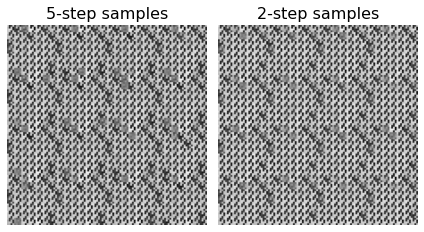

In [76]:
from einops import rearrange

x_samples_5_plot = rearrange(x_samples_5, "(n1 n2) h w 1 -> (n1 h) (n2 w)", n1=4)
x_samples_2_plot = rearrange(x_samples_2, "(n1 n2) h w 1 -> (n1 h) (n2 w)", n1=4)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(x_samples_5_plot, cmap="binary_r")
ax1.axis("off")
ax1.set_title("5-step samples", fontsize=16)

ax2.imshow(x_samples_2_plot, cmap="binary_r")
ax2.axis("off")
ax2.set_title("2-step samples", fontsize=16)

plt.tight_layout()
# plt.savefig("plots/mnist_samples.png")